# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [3]:
import plotly.express as px
churn_data['LoyalStatus'] = churn_data['Exited'].apply(lambda x: 'Loyal' if x==0 else 'Exited')
fig = px.pie(churn_data, 
             'LoyalStatus', 
             title='Соотношение количества лояльных и ушедших клиентов')
fig.show()

Комментарий:<br>
Количество лояльных клиентов превышает количество ушедших почти в 4 раза.<br>
Для того, чтобы понять, является ли доля ушедших клиентов в размере около 20% проблемой или нормой, надо представлять специфику отрасли.

In [4]:
fig = px.box(churn_data, 
             x="Balance", 
             y='LoyalStatus', 
             points="all", 
             title='Распределение баланса клиентов в зависимости от их лояльности', 
             labels={'Balance': 'Баланс', 'LoyalStatus': 'Статус клиента'})
fig.show()

Комментарии:<br>
В ходе анализа полной выборки клиентов замечено, что модальное значение баланса уходящих клиентов находится выше, чем у лояльных. Кроме того, на графике видно, что среди уходящих клиентов подавляющее большинство с ненулевым балансом.

Как один из вариантов, клиентов не устраивают условия процента на остаток. Но нельзя исключать и другие моменты (неудобные приложения, комиссии за операции, отсутствие банкоматов и прочие неудобства).

In [5]:
fig = px.box(churn_data, 
             x="Age", 
             y='LoyalStatus', 
             title='Распределение клиентов по возрасту в зависимости от их лояльности', 
             labels={'Age': 'Возраст', 'LoyalStatus': 'Статус клиента'}, 
             points='all')
fig.show()

Комментарии:<br>
Модальное значение возраста уходящих клиентов (45 лет) выше, чем у остающихся лояльных (36 лет).<br>
При этом полный диапазон возрастов лояльных клиентов шире, чем уходящих.
Особое внимание банку стоит обратить внимание на клиентов в возрастном диапазоне с 38 лет по 51 год.

In [6]:
churn_data_gender = churn_data.groupby(['Gender'])['Exited'].mean()*100

fig = px.bar(churn_data_gender, 
                   x=churn_data_gender.index, 
                   y='Exited', 
                   title='Доля ушедших клиентов среди мужчин и женщин, %',
                   labels={'Gender':'Пол', 'Exited': 'Доля от всех клиентов этого пола'},
                   text_auto=True)
fig.show()

Комментарии:<br>
Женщины в 1,5 раза чаще покидают список лояльных клиентов банка, чем мужчины.

In [7]:
churn_data['iscount'] = 1
churn_data_serv = churn_data.pivot_table(values='iscount', index='NumOfProducts', columns='LoyalStatus', aggfunc=sum)
fig = px.bar(churn_data_serv, 
                   x=churn_data_serv.index, 
                   y=['Exited', 'Loyal'], 
                   title='Зависимость оттока клиентов от количества оказанных банком услуг', 
                   text_auto=True)
fig.show()

Комментарии:<br>
Лояльными в основном являются те клиенты банка, которые воспользовались услугами 1 или 2 раза.<br>
При этом, наибольший отток клиентов в абсолютном значении происходит сразу после первой услуги.<br>
Наибольший же отток в процентном отношении - по мере увеличения количества повторных обращений. Так, после 3-й услуги уже более 80% клиентов уходят, а после 4-й вообще все 100%.<br>
Такое ощущение, что работа с клиентами проводится только при первом обращении. Чем дальше, тем хуже условия или сервис.

In [8]:
churn_data_active = churn_data.pivot_table(values='iscount', index='IsActiveMember', columns='LoyalStatus', aggfunc=sum)
fig = px.bar(churn_data_active, 
                   x=churn_data_active.index, 
                   y=['Exited', 'Loyal'], 
                   title='Зависимость ухода клиентов от их активности', 
                   text_auto=True)
fig.show()

Комментарии:<br>
Доля ушедших клиентов среди неактивных почти в два раза больше, чем среди активных.<br>
Рекомендация - максимально стараться переводить неактивных клиентов в разряд активных, вовлекать. Способы и методы - акции, кэшбэки и т.п.

In [9]:
churn_data_country = churn_data.groupby('Geography')['Exited'].mean()*100

fig = px.choropleth(
    churn_data_country,
    locations = churn_data_country.index,
    locationmode = "country names",
    color = "Exited", 
    title='Доля ушедших клиентов по регионам',
    color_continuous_scale='blues'
)

fig.show()

Комментарии:<br>
В Германии отток клиентов в 2 раза выше (32%), чем в Испании и Франции (по 16%).<br>
Данный разброс может обуславливаться различиями в пакетах услуг по разным регионам, конкурентными предложениями для клиентов, страной-владельцем банка и т.д.

/var/folders/0v/d10yh6tj1mn387jzy55lmxv80000gn/T/ipykernel_1146/3127556386.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

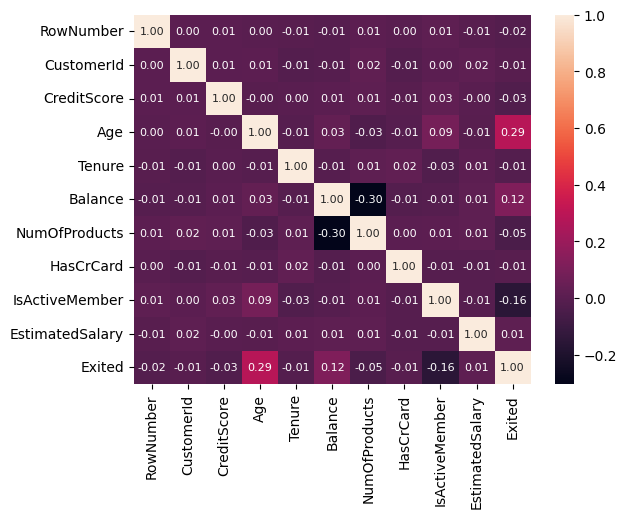

In [10]:
sns.heatmap(churn_data.drop(['iscount'], axis=1).corr(), annot=True, annot_kws={"fontsize":8}, fmt='.2f')

Наибольшая корреляция с фактом ухода клиента наблюдается с признаком возраст (0,29), 
еще 2 признака с небольшой зависимостью - это Активность и Баланс. 
Корреляция с остальными признаками практически отсутствует.

________________________________________________________________________________

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [11]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 16)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [12]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname', 'LoyalStatus', 'iscount'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [13]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [14]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [15]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']
churn_data['Gender_bin'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.drop(['Gender'], axis=1, inplace=True)
churn_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_bin
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517,0
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889,1
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621,1
26,756,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000,1
28,574,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837,0


In [16]:
churn_data.describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_bin
count,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.0,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00
mean,651.45,39.77,5.01,119730.12,1.52,0.71,0.5,101113.44,0.32,9.02,0.13,17.53,0.52
std,98.17,10.52,2.94,27022.01,0.62,0.45,0.5,58263.01,0.47,214.29,0.09,5.35,0.50
min,350.00,18.00,0.00,27288.43,1.00,0.00,0.0,11.58,0.00,0.19,0.00,6.11,0.00
25%,584.00,32.00,2.00,102800.72,1.00,0.00,0.0,51016.02,0.00,0.78,0.06,13.69,0.00
50%,651.00,38.00,5.00,119703.10,1.00,1.00,0.0,102397.22,0.00,1.20,0.12,16.86,1.00
75%,722.00,45.00,8.00,137560.38,2.00,1.00,1.0,151083.80,1.00,2.40,0.20,20.85,1.00
max,850.00,84.00,10.00,214346.96,4.00,1.00,1.0,199970.74,1.00,10614.66,0.50,46.39,1.00


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [17]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [18]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [20]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [21]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


В качестве метрики будем использовать F-меру, т.к. она учитывает оба показателя
(precision и recall), что позволяет найти баланс между ними.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

F-мера используется в задачах, где необходимо балансировать между precision и recall.

Максимум достигается, когда максимальны обе метрики, минимум — когда хотя бы одна из метрик равна 0.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [22]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Рассчитываем F1-меру для тренировочной выборки
print('F1 score train: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Рассчитываем F1-меру для тестовой выборки
print('F1 score test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 score train: 0.512
F1 score test: 0.494


На тестовой выборке F1-мера показывает значение меньше 0.5, что для нас является
неудовлетворительным результатом, т.к. модель недообученная.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [23]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled)

#Создаем объект класса логистическая регрессия
log_reg_poly = linear_model.LogisticRegression(
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg_poly.fit(X_train_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_poly_pred = log_reg_poly.predict(X_train_poly)
#Рассчитываем F1-меру для тренировочной выборки
print('F1 score train: {:.3f}'.format(metrics.f1_score(y_train, y_train_poly_pred)))
#Делаем предсказание для тестовой выборки
y_test_poly_pred = log_reg_poly.predict(X_test_poly)
#Рассчитываем F1-меру для тестовой выборки
print('F1 score test: {:.3f}'.format(metrics.f1_score(y_test, y_test_poly_pred)))

F1 score train: 0.773
F1 score test: 0.642


Очевидно, что полиномиальные признаки улучшили результаты модели как в части тренировочной,
так и в части тестовой выборки. Данный сценарий дает лучшие результаты, чем только с масштабированием, 
но без полиномиальной доработки.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [24]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_pred_poly)
    # Добавляем результат в список
    scores.append(score)

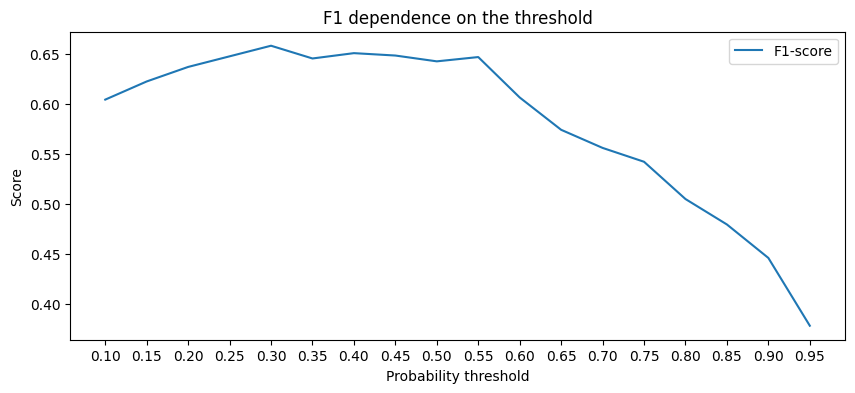

In [25]:
#Визуализируем метрику при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

Наибольшее значение F1-меры на тестовой выборке наблюдается при пороге вероятности 0.30.

In [26]:
# Делаем предсказание вероятности оттока для каждого клиента из тренировочной выборки
y_train_proba_pred = pd.Series(log_reg_poly.predict_proba(X_train_poly)[:, 1])
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_poly)[:, 1])
#Задаём оптимальный порог вероятностей
threshold_opt = 0.3
#Рассчитываем результаты по модели с учетом оптимального порога
y_train_pred_poly_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_test_pred_poly_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

#Рассчитываем F1-меру для тренировочной выборки
print('F1 score train: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred_poly_opt)))
#Рассчитываем F1-меру для тестовой выборки
print('F1 score test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred_poly_opt)))

F1 score train: 0.776
F1 score test: 0.658


На графике видно, что F1-мера не очень сильно отличается при пороге 0.5 и при пороге 0.3. 
При этом, небольшое улучшение результата модели есть. Это лучший из полученных результатов.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [39]:
#снова загружаем исходные данные
churn_data = pd.read_csv('data/churn.csv')
#отбираем только данные, отонсящиеся к отделениям банка в Германии
churn_data = churn_data[churn_data['Geography'] == 'Germany']
#удаляем неинформативные признаки
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
#расширяем датасет путём добавления новых признаков
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']
#переводим признак Gender в бинарный
churn_data['Gender_bin'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.drop(['Gender'], axis=1, inplace=True)
#разделяем на фичи и таргет
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [41]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [42]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_big = tree.DecisionTreeClassifier(
    criterion='entropy', #используем энтропию Шеннона
    random_state=42
)

#Обучаем дерево решений на тренировочной выборке
dt_clf_big.fit(X_train, y_train)

#Делаем предсказание класса для тренировочного набора данных
y_train_pred = dt_clf_big.predict(X_train)
#Выводим значение F1-меры для тренировочного набора данных
print('F1_score train: ',metrics.f1_score(y_train, y_train_pred))

#Делаем предсказание класса для тестового набора данных
y_test_pred = dt_clf_big.predict(X_test)
#Выводим значение F1-меры для тестового набора данных
print('F1_score test: ',metrics.f1_score(y_test, y_test_pred))

F1_score train:  1.0
F1_score test:  0.5265822784810126


Модель получилась явно переобученной. 

Она со 100%-й точностью определяет принадлежность
к классу на выборке для обучения, но при этом на тестовой выборке показатель практически
на уровне "орел/решка".

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [43]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_deep_8 = tree.DecisionTreeClassifier(
    criterion='entropy', #используем энтропию Шеннона
    max_depth=8, #максимальную глубину дерева ограничим 8 уровнями
    min_samples_leaf=10, #минимальное число объектов в листе
    random_state=42
)

#Обучаем дерево решений на тренировочной выборке
dt_clf_deep_8.fit(X_train, y_train)

#Делаем предсказание класса для тренировочного набора данных
y_train_pred_8 = dt_clf_deep_8.predict(X_train)
#Выводим значение F1-меры для тренировочного набора данных
print('F1_score train: ',metrics.f1_score(y_train, y_train_pred_8))

#Делаем предсказание класса для тестового набора данных
y_test_pred_8 = dt_clf_deep_8.predict(X_test)
#Выводим значение F1-меры для тестового набора данных
print('F1_score test: ',metrics.f1_score(y_test, y_test_pred_8))

F1_score train:  0.7172538392050587
F1_score test:  0.6505376344086021


Качество предсказания для тренировочной выборки упало по сравнению с неограниченной глубиной дерева.
В то же время, качество предсказания для тестовой выборки выросло по сравнению с предыдущей итерацией.

Переобученность модели серьезно снизилась. За счет ограничения глубины модель определяет 
закономерности распределения по классам, но в то же время не подстраивается полностью под тренировочный набор.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [44]:
#Создаём объект класса случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf=10, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)

#Обучаем модель 
rf_clf.fit(X_train, y_train)

#Делаем предсказание класса для тренировочного набора данных
y_train_pred_rf = rf_clf.predict(X_train)
#Выводим значение F1-меры для тренировочного набора данных
print('F1_score train: ',metrics.f1_score(y_train, y_train_pred_rf))

#Делаем предсказание класса для тестового набора данных
y_test_pred_rf = rf_clf.predict(X_test)
#Выводим значение F1-меры для тестового набора данных
print('F1_score test: ',metrics.f1_score(y_test, y_test_pred_rf))

F1_score train:  0.7288135593220338
F1_score test:  0.6446280991735537


На тренировочной выборке показатель незначительно повысился, однако на тестовой выборке незначительно снизился.

В целом результаты отдельного дерева и случайного леса сопоставимы, разница в значениях показателя F1-мера для тестовой выборки менее 1%, поэтому на основании проведенных вычислений лидера выбрать сложно.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

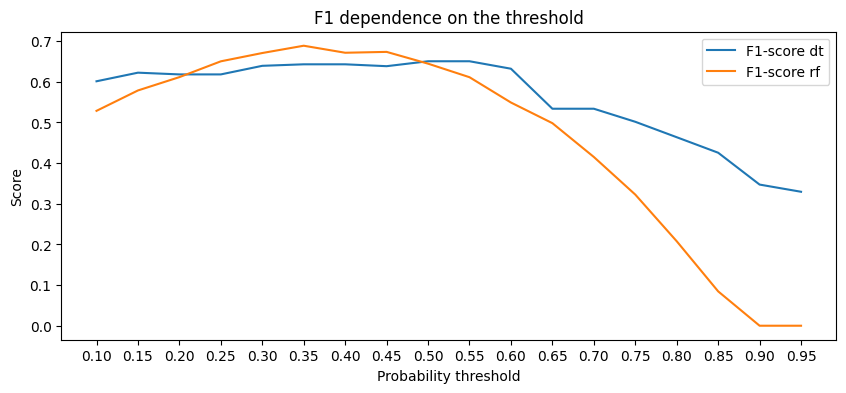

In [45]:
#Поскольку на основании ранее произведенных вычислений однозначно модель выбрать не удалось,
#построим совмещенный график целевой метрики по обеим моделям, чтобы выбрать лучший вариант

# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки - отдельное дерево
y_test_proba_pred_dt = pd.Series(dt_clf_deep_8.predict_proba(X_test)[:, 1])
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки - случайный лес
y_test_proba_pred_rf = pd.Series(rf_clf.predict_proba(X_test)[:, 1])
# Инициализируем списки, куда будем сохранять метрики.
scores_dt = []
scores_rf = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    
    # Делаем предсказание по модели отдельного дерева
    y_test_pred_dt = y_test_proba_pred_dt.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score_dt = metrics.f1_score(y_test, y_test_pred_dt)
    # Добавляем результат в список
    scores_dt.append(score_dt)
    
    # Делаем предсказание по модели случайного леса
    y_test_pred_rf = y_test_proba_pred_rf.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score_rf = metrics.f1_score(y_test, y_test_pred_rf)
    # Добавляем результат в список
    scores_rf.append(score_rf)
    
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_dt, label='F1-score dt')
ax.plot(thresholds, scores_rf, label='F1-score rf')

#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

In [47]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки по модели случайный лес
y_test_proba_pred_rf = pd.Series(rf_clf.predict_proba(X_test)[:, 1])
# Задаем значение порога вероятности с лучшим показателем метрики F1-score
threshold_optimal = 0.35
# Прогнозируем принадлежность к классу с использованием выбранного порога
y_test_pred_rf = y_test_proba_pred_rf.apply(lambda x: 1 if x > threshold_optimal else 0)
# Рассчитываем метрику на тестовой выборке
print('F1-score test: ',metrics.f1_score(y_test, y_test_pred_rf))

F1-score test:  0.6887417218543046


В последней итерации получен лучший результат из всех имеющихся по результатам приведенного выше анализа.

Выбор пал в пользу модели случайного леса, т.к. именно в ней выбранная метрика F1-score достигла своего максимума на тестовой выборке. В то же время, мы не экспериментировали с другими показателями моделей (минимальное количество объектов в листе, глубина) для того, чтобы еще более обоснованно подтвердить свой выбор. В рамках данного задания такая задача не была поставлена, хотя логика подсказывает, что этот эксперимент в реальной жизни тоже целесообразен.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [58]:
data_dict = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}

data = pd.DataFrame.from_dict(data_dict)

#расширяем датасет путём добавления новых признаков
data['BalanceSalaryRatio'] = data['Balance'] / data['EstimatedSalary']
data['TenureByAge'] = data['Tenure'] / data['Age']
data['CreditScoreGivenAge'] = data['CreditScore'] / data['Age']
#переводим признак Gender в бинарный
data['Gender_bin'] = data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
data.drop(['Gender'], axis=1, inplace=True)

print('Вероятность отказа от услуг банка: ',round(rf_clf.predict_proba(data)[0, 1]*100,2),'%')

Вероятность отказа от услуг банка:  62.24 %
